# Python intensive, part 6

## Putting it all together: exploring storm data

For our final section, we are going to do some exploratory analysis of a real world dataset, coding in pairs or groups as we did on the previous days. There are several different "paths" you can choose to follow based on what you are interested in working on, so either come to a consensus within your group, or group up based on shared interest! First, let's download our data:

In [2]:
# This line downloads the file locally to the same folder as your notebook
!wget https://raw.githubusercontent.com/harvardinformatics/python-intensive/refs/heads/main/data/indiana_storms_full.csv

import os

# This line stores the local file path as a Python string variable
storms_file = 'indiana_storms_full.csv'
if not os.path.isfile(storms_file):
    storms_file = 'data/indiana_storms_full.csv'


'wget' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
import pandas as pd
storms_df = pd.read_csv(storms_file)
storms_df.head()

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,...,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE
0,201501,8,1700,201501,9,1200,91570,548696,INDIANA,18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A quick-moving Alberta Clipper brought a quick...,Periods of snow during the late afternoon hour...,CSV
1,201501,5,2200,201501,6,830,92441,555468,INDIANA,18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,An Alberta Clipper brought a quick round of sn...,Snowfall accumulation observations ranged from...,CSV
2,201501,5,2200,201501,6,900,92441,555469,INDIANA,18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,An Alberta Clipper brought a quick round of sn...,Snowfall accumulation observations ranged from...,CSV
3,201501,5,2200,201501,6,900,92441,555470,INDIANA,18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,An Alberta Clipper brought a quick round of sn...,Snowfall accumulation observations ranged from...,CSV
4,201501,5,2215,201501,6,930,92441,555471,INDIANA,18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,An Alberta Clipper brought a quick round of sn...,Snowfall accumulation of 5.5 inches was report...,CSV


In [4]:
storms_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1315 entries, 0 to 1314
Data columns (total 51 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   BEGIN_YEARMONTH     1315 non-null   int64  
 1   BEGIN_DAY           1315 non-null   int64  
 2   BEGIN_TIME          1315 non-null   int64  
 3   END_YEARMONTH       1315 non-null   int64  
 4   END_DAY             1315 non-null   int64  
 5   END_TIME            1315 non-null   int64  
 6   EPISODE_ID          1315 non-null   int64  
 7   EVENT_ID            1315 non-null   int64  
 8   STATE               1315 non-null   object 
 9   STATE_FIPS          1315 non-null   int64  
 10  YEAR                1315 non-null   int64  
 11  MONTH_NAME          1315 non-null   object 
 12  EVENT_TYPE          1315 non-null   object 
 13  CZ_TYPE             1315 non-null   object 
 14  CZ_FIPS             1315 non-null   int64  
 15  CZ_NAME             1315 non-null   object 
 16  WFO   

## Data Cleaning: subsetting columns

This is a file that contains data from the National Weather Service. It contains data on storm events in the state of Indiana in 2015. There is quite a lot of information in there with 50 columns in the dataset, so before we do any analysis let's do a bit of cleanup! 

We are primarily interested in type of storm event "EVENT_TYPE", the county in which the event occurred "CZ_NAME", and the time of the event "BEGIN_DATE_TIME", "END_DATE_TIME", "CZ_TIMEZONE". Let's also throw in there "BEGIN_LOCATION", "END_LOCATION", "BEGIN_LAT", "BEGIN_LON", "END_LAT", and "END_LON" just in case. So the first thing we need to do is subset the data to only include these columns.

In [5]:
storms_df = storms_df[["EVENT_TYPE", "CZ_NAME", "BEGIN_DATE_TIME", "END_DATE_TIME", "CZ_TIMEZONE",  "BEGIN_LOCATION", "END_LOCATION", "BEGIN_LAT", "BEGIN_LON", "END_LAT", "END_LON"]]

Now, let's check if there are any missing values in the columns we are interested in. If there are, we should remove the rows with missing values.

In [6]:
storms_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1315 entries, 0 to 1314
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   EVENT_TYPE       1315 non-null   object 
 1   CZ_NAME          1315 non-null   object 
 2   BEGIN_DATE_TIME  1315 non-null   object 
 3   END_DATE_TIME    1315 non-null   object 
 4   CZ_TIMEZONE      1315 non-null   object 
 5   BEGIN_LOCATION   871 non-null    object 
 6   END_LOCATION     871 non-null    object 
 7   BEGIN_LAT        871 non-null    float64
 8   BEGIN_LON        871 non-null    float64
 9   END_LAT          871 non-null    float64
 10  END_LON          871 non-null    float64
dtypes: float64(4), object(7)
memory usage: 113.1+ KB


Only some storm events have a begin and end location, but at least there aren't any that only have a begin and not and end. Data looks good! The next thing we need to do is to convert the "BEGIN_DATE_TIME" and "END_DATE_TIME" columns to datetime objects. Additionally, these data are spread out over two time zones and we want to convert it to a single time zone for clarity. This will make it easier to work with these columns later on. For more information on the proper way to manage dates and times in Python, see the section in our Python Healthy Habits document "Working with dates and times". 

In [7]:
# Convert all date time columns to datetime objects with correct timezone parsing
# I wrote a regex to extract just the number from the timezone column and then made it an ISO8601 compliant timezone string
# Pandas does not support multiple time zones in the same column, so we will convert all times to UTC and then convert to one of the local time zones
storms_df['BEGIN_DATE_TIME'] = pd.to_datetime(storms_df["BEGIN_DATE_TIME"]+"-0"+storms_df["CZ_TIMEZONE"].str.extract(r'([0-9]+)')[0]+"00", format="mixed", utc=True).dt.tz_convert("-05:00")
storms_df['END_DATE_TIME'] = pd.to_datetime(storms_df["END_DATE_TIME"]+"-0"+storms_df["CZ_TIMEZONE"].str.extract(r'([0-9]+)')[0]+"00", format="mixed", utc=True).dt.tz_convert("-05:00")

Here's a breakdown of the code I used to convert the "BEGIN_DATE_TIME" and "END_DATE_TIME" columns to datetime objects:

```python
storms_df['BEGIN_DATE_TIME'] = pd.to_datetime(storms_df["BEGIN_DATE_TIME"]+"-0"+storms_df["CZ_TIMEZONE"].str.extract(r'([0-9]+)')[0]+"00", format="mixed", utc=True).dt.tz_convert("-05:00")
```

| Code                                                              | Explanation |
| ----------------------------------------------------------------- | ----------- |
| `pd.to_datetime()`                                                | This function converts a string or a list of strings to a datetime object. However, I first need to convert the string into something that is can parse.|
| `storms_df["BEGIN_DATE_TIME"]`                                    | This column is alredy in a format that pandas can parse, but it is missing the time zone information.|
| `+"-0"+storms_df["CZ_TIMEZONE"].str.extract(r'([0-9]+)')[0]+"00"` | This adds the time zone offset to the string by concatenating `-0` and the regex match for the time zone offset. Plus, it adds `00` to the end to represent the minutes.|
| `format="mixed"`                                                  | This tells pandas to try to parse the string in a mixed format, which means it will attempt to infer the format of the date and time.|
| `utc=True`                                                        | This tells pandas to treat the datetime object as UTC time, which is a standard time zone that is not affected by daylight savings time.|
| `.dt.tz_convert("-05:00")`                                        | This converts the datetime object to the specified time zone, which is Eastern Standard Time (EST) in this case.|


Here's what the times look like now:

In [8]:
storms_df["BEGIN_DATE_TIME"].head()

0   2015-01-08 17:00:00-05:00
1   2015-01-05 22:00:00-05:00
2   2015-01-05 22:00:00-05:00
3   2015-01-05 22:00:00-05:00
4   2015-01-05 22:15:00-05:00
Name: BEGIN_DATE_TIME, dtype: datetime64[ns, UTC-05:00]

In [9]:
storms_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1315 entries, 0 to 1314
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype                    
---  ------           --------------  -----                    
 0   EVENT_TYPE       1315 non-null   object                   
 1   CZ_NAME          1315 non-null   object                   
 2   BEGIN_DATE_TIME  1315 non-null   datetime64[ns, UTC-05:00]
 3   END_DATE_TIME    1315 non-null   datetime64[ns, UTC-05:00]
 4   CZ_TIMEZONE      1315 non-null   object                   
 5   BEGIN_LOCATION   871 non-null    object                   
 6   END_LOCATION     871 non-null    object                   
 7   BEGIN_LAT        871 non-null    float64                  
 8   BEGIN_LON        871 non-null    float64                  
 9   END_LAT          871 non-null    float64                  
 10  END_LON          871 non-null    float64                  
dtypes: datetime64[ns, UTC-05:00](2), float64(4), object(5)
m

## Warm-up exercises

Here are some warm-up exercises to get started working with data that is a mix of categorical and datetime data. One helpful tip to working with datetime objects is to get the series of the datetime object and then use the `.dt` accessor to access the datetime properties. You can find all the properties of the datetime object [here](https://pandas.pydata.org/docs/reference/api/pandas.DatetimeIndex.html).

In [10]:
# example of getting an attribute of a datetime object

storms_df["END_DATE_TIME"].dt.day_of_year

0         9
1         6
2         6
3         6
4         6
       ... 
1310    357
1311    357
1312    365
1313    357
1314      1
Name: END_DATE_TIME, Length: 1315, dtype: int32

In [11]:
# example of using a method of a datetime object

storms_df["END_DATE_TIME"].dt.month_name()

0        January
1        January
2        January
3        January
4        January
          ...   
1310    December
1311    December
1312    December
1313    December
1314     January
Name: END_DATE_TIME, Length: 1315, dtype: object

The next three exercises are one-liners what will use the method `.value_counts()` to get the number of rows for each unique value in a column. This is a useful method to get a sense of the distribution of the data in a column. Below, we demonstrate by counting the number of each event type. (Compare this to the `groupby().size()` method we used last time)

In [12]:
storms_df["EVENT_TYPE"].value_counts()

EVENT_TYPE
Thunderstorm Wind          383
Hail                       187
Winter Weather             162
Heavy Snow                 131
Flood                      125
Flash Flood                121
Dense Fog                   40
Winter Storm                33
Heavy Rain                  27
Extreme Cold/Wind Chill     26
Tornado                     24
Heat                        15
Cold/Wind Chill             12
Excessive Heat               6
Frost/Freeze                 6
Strong Wind                  5
Ice Storm                    3
Lightning                    3
High Wind                    2
Lake-Effect Snow             2
Funnel Cloud                 1
Blizzard                     1
Name: count, dtype: int64

>**Exercise:** Are storms more common on weekends or weekdays? YES/NO. Display your answer by counting the number of events that happend on each day of the week. Don't worry about sorting the days of the week, just display the counts. Look at the datetime object documentation to see how to get the day of the week from the `.dt` accessor. 

In [13]:
# Your code here

In [14]:
#@title Solution {display-mode: "form"}

storms_df['BEGIN_DATE_TIME'].dt.day_name().value_counts()

BEGIN_DATE_TIME
Monday       275
Wednesday    208
Friday       205
Sunday       188
Saturday     166
Tuesday      154
Thursday     119
Name: count, dtype: int64

>**Exercise:** Which events tend to span more than one county? Display the counts of each event type that spans more than one county. (Hint: Events which span more than one county will have non-null values for `BEGIN_LOCATION` and `END_LOCATION`.) 

In [15]:
# Your code here

In [16]:
#@title Solution {display-mode: "form"}

storms_df[~storms_df["BEGIN_LOCATION"].isna()]["EVENT_TYPE"].value_counts()

EVENT_TYPE
Thunderstorm Wind    383
Hail                 187
Flood                125
Flash Flood          121
Heavy Rain            27
Tornado               24
Lightning              3
Funnel Cloud           1
Name: count, dtype: int64

>**Exercise:** Which events tend to be multi-day events? Display the counts of each event type that has a duration of more than 1 day (24 hours).
>
>You will need to use the `pd.Timedelta()` function in your filtering criteria. Docs [here](https://pandas.pydata.org/docs/user_guide/timedeltas.html) and [here](https://pandas.pydata.org/docs/reference/api/pandas.Timedelta.html#pandas.Timedelta)

In [17]:
# Your code here

In [18]:
#@title Solution {display-mode: "form"}

# Find duration of events
storms_df['EVENT_DURATION'] = storms_df["END_DATE_TIME"] - storms_df["BEGIN_DATE_TIME"]

# filter for events that last more than one day and count them
storms_df[storms_df['EVENT_DURATION'] > pd.Timedelta(days=1)]["EVENT_TYPE"].value_counts()

EVENT_TYPE
Flood                      48
Heavy Snow                 24
Excessive Heat              6
Winter Storm                4
Winter Weather              3
Blizzard                    1
Flash Flood                 1
Extreme Cold/Wind Chill     1
Lake-Effect Snow            1
Name: count, dtype: int64

>**Exercise:** Create two lists: a list of all county names and a list of all event types. How many counties and event types are there? You will be using the Series methods `.unique()` and `.tolist()` here. 

In [19]:
# Your code here

In [20]:
#@title Solution {display-mode: "form"}

county_list = storms_df["CZ_NAME"].unique().tolist()
print(county_list)
print(f"There are {len(county_list)} counties in the dataset")
event_list = storms_df["EVENT_TYPE"].unique().tolist()
print(event_list)
print(f"There are {len(event_list)} event types in the dataset")

['NOBLE', 'MADISON', 'DELAWARE', 'HENRY', 'RANDOLPH', 'MARION', 'STEUBEN', 'LAGRANGE', 'WHITLEY', 'KOSCIUSKO', 'HANCOCK', 'FAYETTE', 'WAYNE', 'FRANKLIN', 'DEARBORN', 'MARSHALL', 'LA PORTE', 'ELKHART', 'WHITE', 'GIBSON', 'PIKE', 'POSEY', 'SPENCER', 'VANDERBURGH', 'WARRICK', 'CASS', 'PULASKI', 'MIAMI', 'FULTON', 'STARKE', 'ST. JOSEPH', 'ALLEN', 'WABASH', 'HUNTINGTON', 'WELLS', 'ADAMS', 'GRANT', 'BLACKFORD', 'JAY', 'PORTER', 'TIPPECANOE', 'RIPLEY', 'UNION', 'SWITZERLAND', 'CLINTON', 'HOWARD', 'TIPTON', 'BOONE', 'HAMILTON', 'DE KALB', 'ORANGE', 'CRAWFORD', 'BROWN', 'JOHNSON', 'PERRY', 'CLARK', 'HARRISON', 'MARTIN', 'WASHINGTON', 'DAVIESS', 'RUSH', 'DUBOIS', 'MONROE', 'KNOX', 'FLOYD', 'VERMILLION', 'HENDRICKS', 'MORGAN', 'JEFFERSON', 'SCOTT', 'JENNINGS', 'PARKE', 'OWEN', 'PUTNAM', 'WARREN', 'NEWTON', 'GREENE', 'CARROLL', 'SHELBY', 'MONTGOMERY', 'FOUNTAIN', 'JACKSON', 'Vanderburgh', 'Warrick', 'JASPER', 'SULLIVAN', 'DECATUR', 'VIGO', 'LAKE', 'LAWRENCE', 'BARTHOLOMEW', 'Spencer', 'Gibson', 'O

>**Exercise:** Function-writing warmup. Write a function called `get_event_county` that takes as input the storms dataframe object, a county name (as a string), and an event type (as a string). The function should return a dataframe that contains only that county and event type.
>
> This function is ideally a one-liner that filters the dataframe based on two criteria. Remember to enclose each condition in `()` and use the `&` operator to combine them.

In [21]:
# Your code here

In [22]:
# test your code
# should return a dataframe with 7 rows
get_event_county(storms_df, "ELKHART", "Thunderstorm Wind")

NameError: name 'get_event_county' is not defined

In [ ]:
#@title Solution {display-mode: "form"}

def get_event_county(storms, county, event):
    return storms[(storms["EVENT_TYPE"] == event) & (storms["CZ_NAME"] == county)]

get_event_county(storms_df, "ELKHART", "Thunderstorm Wind")

Now that we have imported our data, cleaned it up and begun to explore it, let's split off into groups! We have a few paths we can take:

1. A guided path: We will guide you through writing functions that summarize and print the data in different ways. This will help you practice writing functions, filtering data, and practice a tiny bit of plotting. 
2. A few self-guided exploratory questions that you can approach however you want, but focus on different skills:
    * Question 1: What is the most dangerous county in Indiana? We provide a separate table of county info so you can normalize the data by county area. You will need to learn how to merge two dataframes together.
    * Question 2: What is the best time to visit Indiana if you want to take cool pictures of clouds? This will help you practice summarizing data and, depending on how you approach it, work with date time objects of various duration. 
    * Question 3: Create a plot that compares the duration in hours of each common event type. This will help you practice creating new columns and plotting data. 

## Path 1: function writing practice

1. Write a function called `storm_by_county` that takes as input the storms object, a **LIST** of county names, and returns a dataframe of all of the events that occurred in a given county and the date they began. Include an optional argument `storm_type` that by default is `None` and includes all event types, but if given a list, only includes those events.

In [ ]:
# Your code here

In [23]:
# test your function
# should return 8 rows of data
storm_by_county(storms_df, ["OHIO"])

NameError: name 'storm_by_county' is not defined

In [24]:
# test your function
# should return 11 rows of data

storm_by_county(storms_df, ["ELKHART", "ST. JOSEPH"], ["Thunderstorm Wind"])

NameError: name 'storm_by_county' is not defined

In [25]:
#@title Solution {display-mode: "form"}

def storm_by_county(storms, county, storm_type=None):
    if storm_type:
        matches = storms[(storms['CZ_NAME'].isin(county)) & (storms['EVENT_TYPE'].isin(storm_type))]
    else:
        matches = storms[(storms['CZ_NAME'].isin(county))]
    
    return matches

storm_by_county(storms_df, ["OHIO"])

print("...")

storm_by_county(storms_df, ["ELKHART", "ST. JOSEPH"], ["Thunderstorm Wind"])

...


,EVENT_TYPE,CZ_NAME,BEGIN_DATE_TIME,END_DATE_TIME,CZ_TIMEZONE,BEGIN_LOCATION,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EVENT_DURATION
281,Thunderstorm Wind,ST. JOSEPH,2015-06-11 15:26:00-05:00,2015-06-11 15:26:00-05:00,EST-5,ROSELAND,ROSELAND,41.7226,-86.2559,41.7226,-86.2559,0 days 00:00:00
480,Thunderstorm Wind,ST. JOSEPH,2015-06-08 16:30:00-05:00,2015-06-08 16:30:00-05:00,EST-5,GRANGER,GRANGER,41.7400,-86.1400,41.7400,-86.1400,0 days 00:00:00
571,Thunderstorm Wind,ST. JOSEPH,2015-07-18 17:43:00-05:00,2015-07-18 17:46:00-05:00,EST-5,GILMER PARK,GILMER PARK,41.6285,-86.2971,41.6285,-86.2971,0 days 00:03:00
572,Thunderstorm Wind,ELKHART,2015-07-18 17:55:00-05:00,2015-07-18 17:58:00-05:00,EST-5,JAMESTOWN,JAMESTOWN,41.6400,-86.0200,41.6400,-86.0200,0 days 00:03:00
574,Thunderstorm Wind,ELKHART,2015-07-18 17:58:00-05:00,2015-07-18 18:01:00-05:00,EST-5,ELKHART,ELKHART,41.7026,-85.9467,41.7026,-85.9467,0 days 00:03:00
582,Thunderstorm Wind,ST. JOSEPH,2015-07-18 18:04:00-05:00,2015-07-18 18:07:00-05:00,EST-5,GLENWOOD,GLENWOOD,41.6700,-86.0800,41.6700,-86.0800,0 days 00:03:00
583,Thunderstorm Wind,ELKHART,2015-07-18 18:15:00-05:00,2015-07-18 18:18:00-05:00,EST-5,BRISTOL,BRISTOL,41.6900,-85.8200,41.6900,-85.8200,0 days 00:03:00
591,Thunderstorm Wind,ELKHART,2015-07-18 18:35:00-05:00,2015-07-18 18:38:00-05:00,EST-5,ELKHART MIDWAY ARPT,ELKHART MIDWAY ARPT,41.6100,-85.8700,41.6100,-85.8700,0 days 00:03:00
592,Thunderstorm Wind,ELKHART,2015-07-13 20:47:00-05:00,2015-07-13 20:50:00-05:00,EST-5,MILLERSBURG,MILLERSBURG,41.5100,-85.7300,41.5100,-85.7300,0 days 00:03:00
608,Thunderstorm Wind,ELKHART,2015-07-18 17:50:00-05:00,2015-07-18 17:53:00-05:00,EST-5,ELKHART,ELKHART,41.6800,-85.9800,41.6800,-85.9800,0 days 00:03:00


2. Create a function called `display_storms` that takes a storms object, iterates through each row, and prints out each event as a sentence, including the event type, the county, and the date and time of the event. This exercise helps with iterating over data. An example output would be: "A thunderstorm occurred in Marion County on 2015-06-15 13:45:00". (as a bonus, you can try and format the date and time to be more human-readable)

**HINT:** You will need to use the `.iterrows()` method

In [ ]:
# Your code here

3. Test your function by:
- Printing all storm events in TIPPECANOE county
- Printing all "Flood" and "Flash Flood" events in the following counties: MARION, MONROE, SPENCER, VERMILLION
- Print all "Tornado" events *in the whole state*, i.e. all the counties.

In [ ]:
## Test your storm_by_county function

# 3.1: Display all storm events in TIPPECANOE county.
print("--- 3.1 ---")
display_storms(storm_by_county(storms_df, ["TIPPECANOE"]))

# 3.2: Display all Flood and Flash Flood events in the following counties: MARION, MONROE, SPENCER, VERMILLION
print("--- 3.2 ---")
counties_to_check = ["MARION", "MONROE", "SPENCER", "VERMILLION"]
storm_types = ["Flood", "Flash Flood"]

display_storms(storm_by_county(storms_df, counties_to_check, storm_types))

# 3.3: Display all Tornado events that occurred in the state.
print("--- 3.3 ---")
county_list = storms_df["CZ_NAME"].unique()
display_storms(storm_by_county(storms_df, county_list, storm_type=["Tornado"]))

In [26]:
#@title Solution {display-mode: "form"}

def display_storms(storms):
    for index, event in storms.iterrows():
        print("A", event["EVENT_TYPE"], "occurred on", event["BEGIN_DATE_TIME"], "in", event["CZ_NAME"], "county.")

# 3.1: Display all storm events in TIPPECANOE county.
print("--- 3.1 ---")
display_storms(storm_by_county(storms_df, ["TIPPECANOE"]))

# 3.2: Display all Flood and Flash Flood events in the following counties: MARION, MONROE, SPENCER, VERMILLION
print("--- 3.2 ---")
counties_to_check = ["MARION", "MONROE", "SPENCER", "VERMILLION"]
storm_types = ["Flood", "Flash Flood"]

display_storms(storm_by_county(storms_df, counties_to_check, storm_types))

# 3.3: Display all Tornado events that occurred in the state.
print("--- 3.3 ---")
county_list = storms_df["CZ_NAME"].unique()
display_storms(storm_by_county(storms_df, county_list, storm_type=["Tornado"]))

--- 3.1 ---
A Heavy Snow occurred on 2015-01-05 21:00:00-05:00 in TIPPECANOE county.
A Hail occurred on 2015-04-08 16:15:00-05:00 in TIPPECANOE county.
A Hail occurred on 2015-04-08 16:25:00-05:00 in TIPPECANOE county.
A Thunderstorm Wind occurred on 2015-06-12 16:37:00-05:00 in TIPPECANOE county.
A Thunderstorm Wind occurred on 2015-06-12 16:40:00-05:00 in TIPPECANOE county.
A Thunderstorm Wind occurred on 2015-06-21 00:15:00-05:00 in TIPPECANOE county.
A Thunderstorm Wind occurred on 2015-06-07 19:15:00-05:00 in TIPPECANOE county.
A Hail occurred on 2015-06-08 19:50:00-05:00 in TIPPECANOE county.
A Thunderstorm Wind occurred on 2015-06-07 18:51:00-05:00 in TIPPECANOE county.
A Thunderstorm Wind occurred on 2015-06-21 00:10:00-05:00 in TIPPECANOE county.
A Thunderstorm Wind occurred on 2015-06-21 00:27:00-05:00 in TIPPECANOE county.
A Thunderstorm Wind occurred on 2015-07-13 09:50:00-05:00 in TIPPECANOE county.
A Tornado occurred on 2015-07-17 15:33:00-05:00 in TIPPECANOE county.
A Fl

4. Make a histogram that displays the count of the events which contain "flood" in the following counties: ["MARION", "MONROE", "SPENCER", "VERMILLION", "TIPPECANOE"]. The x axis will be the different "flood" event types, and the color of the bar will be the county. The y axis will be the count of the events.

HINT: First, you will have to find a way to get all values of `EVENT_TYPE` that contain the word "flood" (case insensitive) and make that into a list. Then, you can pass that list and your county list to your `storm_by_county()` function. There are many ways to get the values that contain "flood". One way is to use `str.contains()`, but will involve chaining a few methods and doing some dataframe subsetting. Another way is to use a for loop and an if statement and may be more readable. 

When you make a histogram using `sns.histplot()`, you can use the `multiple='dodge'` argument to make the bars side by side.

In [ ]:
# Your code here

<Axes: xlabel='EVENT_TYPE', ylabel='Count'>

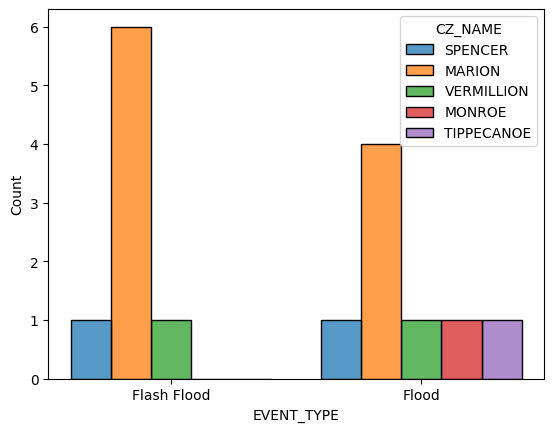

In [27]:
#@title Solution {display-mode: "form"}

# import seaborn
import seaborn as sns

# str.contains method
storm_list = storms_df["EVENT_TYPE"][storms_df["EVENT_TYPE"].str.contains("flood", case=False)].unique().tolist()

# for loop method
storm_list = []
for event in storms_df["EVENT_TYPE"].dropna().unique():
    if "flood" in event.lower():
        storm_list.append(event)

# make a subset
storms_subset = storm_by_county(storms_df, county=["MARION", "MONROE", "SPENCER", "VERMILLION", "TIPPECANOE"], storm_type = storm_list)

# plot the subset
sns.histplot(storms_subset, x="EVENT_TYPE", hue="CZ_NAME", multiple="dodge", shrink=0.8)

5. Write another function called `summarise_storms` which takes as input the storms object you created, a list of counties, and an optional list of `storm_type` that displays only certain storm types (aka the same arguments as `storm_by_county`). Instead of returning every event, it returns a dataframe summarizing the number of occurences of each event in those counties. **HINT** You may want to use your previous function `storm_by_county` to avoid repeating code!

In [ ]:
# Your code here


5. Test your function by:
- Printing the number of all events in PIKE county without printing information about each one
- Printing the total number of "Thunderstorm Wind" events in the following counties: ELKHART, LA PORTE, BOONE

In [ ]:
## Test your modified storm_by_county function

# 5.1 Display the number of all events in PIKE county
print("--- 5.1 ---")
print(summarise_storms(storms_df, ["PIKE"]))

# 5.2 Display the number of Thunderstorm Wind events in the following counties: ELKHART, LA PORTE, BOONE
print("--- 5.2 ---")
print(summarise_storms(storms_df, ["ELKHART", "LA PORTE", "BOONE"], ["Thunderstorm Wind"]))

In [28]:
#@title Solution {display-mode: "form"}

def summarise_storms(storms, county, storm_type=None):
  df = storm_by_county(storms, county, storm_type).groupby(["CZ_NAME","EVENT_TYPE"]).size().reset_index()
  
  return df

# 5.1 Display the number of all events in PIKE county
print("--- 5.1 ---")
print(summarise_storms(storms_df, ["PIKE"]))

# 5.2 Display the number of Thunderstorm Wind events in the following counties: ELKHART, LA PORTE, BOONE
print("--- 5.2 ---")
print(summarise_storms(storms_df, ["ELKHART", "LA PORTE", "BOONE"], ["Thunderstorm Wind"]))

--- 5.1 ---
  CZ_NAME       EVENT_TYPE  0
0    PIKE  Cold/Wind Chill  2
1    PIKE        Dense Fog  5
2    PIKE            Flood  6
3    PIKE     Frost/Freeze  1
4    PIKE       Heavy Snow  1
5    PIKE     Winter Storm  2
6    PIKE   Winter Weather  3
--- 5.2 ---
    CZ_NAME         EVENT_TYPE  0
0     BOONE  Thunderstorm Wind  7
1   ELKHART  Thunderstorm Wind  7
2  LA PORTE  Thunderstorm Wind  5


6. Use your function to summarize the total counts of each weather event in each county.

In [ ]:
# Your code here

In [29]:
#@title Solution {display-mode: "form"}

all_weather = storms_df["EVENT_TYPE"].unique().tolist()
all_counties = storms_df["CZ_NAME"].unique().tolist()

summarise_storms(storms_df, all_counties, all_weather)

,CZ_NAME,EVENT_TYPE,0
0,ADAMS,Extreme Cold/Wind Chill,1
1,ADAMS,Hail,1
2,ADAMS,Heavy Rain,1
3,ADAMS,Heavy Snow,1
4,ADAMS,Winter Weather,5
...,...,...,...
473,WHITLEY,Heavy Snow,2
474,WHITLEY,Winter Weather,5
475,Warrick,Dense Fog,1
476,Warrick,Excessive Heat,1


## Self-guided exploratory questions

Here are a few questions we've come up with that can be approached in multiple different ways.

**Question 1:** What is the most dangerous county in Indiana, assuming danger only comes from the storm events? You will need to account for the area of each county to answer this question. We've provided code to get the table from wikipedia that lists county information. 

In [32]:
!pip install lxml
county_info = pd.read_html("https://en.wikipedia.org/wiki/List_of_counties_in_Indiana", storage_options={"User-Agent": "Mozilla/5.0"})
county_info = county_info[1]


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


You will need to do some data cleaning to get the county names to match up and to extract the area of each county. Then you will need to merge the two dataframes together. 

In [33]:
county_info[["County", "Area[3][12]"]]

,County,Area[3][12]
0,Adams County,339 sq mi (878 km2)
1,Allen County,"657 sq mi (1,702 km2)"
2,Bartholomew County,"407 sq mi (1,054 km2)"
3,Benton County,"406 sq mi (1,052 km2)"
4,Blackford County,165 sq mi (427 km2)
...,...,...
87,Washington County,"514 sq mi (1,331 km2)"
88,Wayne County,"402 sq mi (1,041 km2)"
89,Wells County,368 sq mi (953 km2)
90,White County,"505 sq mi (1,308 km2)"


In [ ]:
# Your code here

In [34]:
#@title Solution: data cleaning {display-mode: "form"}

# cleaning county_info
county_info["County"] = county_info["County"].str.replace(" County", "").str.upper()
county_info["Area_sq_mi"] = pd.to_numeric(county_info["Area[3][12]"].str.extract(r'([0-9,]+)')[0])

# merge the two dataframes
storms_merged = pd.merge(storms_df, county_info, left_on="CZ_NAME", right_on="County")

In [35]:
#@title Solution: example {display-mode: "form"}

# grouping by county and area
df = storms_merged.groupby(["CZ_NAME", "Area_sq_mi"])["EVENT_TYPE"].count().reset_index()
print(df.head())

# normalizing number of events by area
df["normalized"] = df["EVENT_TYPE"] / df["Area_sq_mi"]

# sorting by normalized value
df.sort_values("normalized", ascending=False)

       CZ_NAME  Area_sq_mi  EVENT_TYPE
0        ADAMS         339           9
1        ALLEN         657          31
2  BARTHOLOMEW         407           7
3       BENTON         406           4
4    BLACKFORD         165           6


,CZ_NAME,Area_sq_mi,EVENT_TYPE,normalized
79,VANDERBURGH,233,34,0.145923
20,FLOYD,148,19,0.128378
46,MARION,396,41,0.103535
9,CLARK,373,37,0.099196
33,HUNTINGTON,383,37,0.096606
...,...,...,...,...
10,CLAY,358,2,0.005587
26,GREENE,543,3,0.005525
7,CARROLL,372,2,0.005376
44,LAWRENCE,449,2,0.004454


**Question 2:** What is the best time to visit Indiana if you want to take cool pictures of clouds? The main idea of this question is to summarize the data in such a way that you can tell which month or week or your choice of span of days has the highest concentration of events of interest. 

In [ ]:
# Your code here

In [36]:
#@title Solution: example {display-mode: "form"}

# decide which weather events probably have cool clouds
cool_clouds = ["Thunderstorm wind", "Tornado", "Lightning", "Heavy Rain"]

# filter for cool clouds
df_clouds = storms_df[storms_df["EVENT_TYPE"].isin(cool_clouds)]

# group by month and number of events
df_clouds.groupby(df_clouds["BEGIN_DATE_TIME"].dt.month)["EVENT_TYPE"].count().reset_index()

,BEGIN_DATE_TIME,EVENT_TYPE
0,1,1
1,2,1
2,3,4
3,4,9
4,5,1
5,6,14
6,7,12
7,8,1
8,10,2
9,11,1


**Question 3:** Create a plot that compares the duration in hours of each common event type. Some events occur only infrequently, so your first step would be to filter those out. Then, you will need to decide what type of plot to make. Take a look at the [seaborn gallery](https://seaborn.pydata.org/examples/index.html). If you are having trouble deciding how to represent your data, take a look at this [infographic](https://github.com/Financial-Times/chart-doctor/blob/main/visual-vocabulary/poster.png)

In [ ]:
# Your code here

In [37]:
#@title Solution: data parsing {display-mode: "form"}

# get event duration. We've already done this, but the code is reproduced before

storms_df["EVENT_DURATION"] = storms_df["END_DATE_TIME"] - storms_df["BEGIN_DATE_TIME"]

# filter out events which only occurred <10 times in the year

storms_filtered = storms_df.groupby("EVENT_TYPE").filter(lambda x: len(x) > 10)

# group by event type and calculate average duration

print(storms_filtered.groupby("EVENT_TYPE")["EVENT_DURATION"].mean())

storms_filtered.groupby("EVENT_TYPE")["EVENT_DURATION"].describe()

EVENT_TYPE
Cold/Wind Chill                     0 days 09:00:00
Dense Fog                           0 days 07:27:00
Extreme Cold/Wind Chill   0 days 12:20:46.153846153
Flash Flood               0 days 02:13:29.256198347
Flood                        4 days 01:25:38.880000
Hail                      0 days 00:01:21.818181818
Heat                                0 days 05:24:00
Heavy Rain                0 days 02:08:44.444444444
Heavy Snow                0 days 16:16:49.923664122
Thunderstorm Wind         0 days 00:00:41.984334203
Tornado                             0 days 00:02:35
Winter Storm              0 days 16:39:05.454545454
Winter Weather            0 days 12:19:15.185185185
Name: EVENT_DURATION, dtype: timedelta64[ns]


,count,mean,std,min,25%,50%,75%,max
EVENT_TYPE,,,,,,,,
Cold/Wind Chill,12,0 days 09:00:00,0 days 02:05:20.154737286,0 days 07:00:00,0 days 07:00:00,0 days 09:00:00,0 days 11:00:00,0 days 11:00:00
Dense Fog,40,0 days 07:27:00,0 days 03:16:24.370352945,0 days 04:00:00,0 days 05:00:00,0 days 05:00:00,0 days 10:00:00,0 days 13:00:00
Extreme Cold/Wind Chill,26,0 days 12:20:46.153846153,0 days 04:00:33.883213306,0 days 03:00:00,0 days 12:00:00,0 days 12:00:00,0 days 12:00:00,1 days 06:00:00
Flash Flood,121,0 days 02:13:29.256198347,0 days 03:20:21.201559833,0 days 00:00:00,0 days 00:00:00,0 days 01:51:00,0 days 03:30:00,1 days 03:35:00
Flood,125,4 days 01:25:38.880000,7 days 03:59:43.207680028,0 days 00:00:00,0 days 01:30:00,0 days 02:18:00,3 days 19:00:00,29 days 09:00:00
Hail,187,0 days 00:01:21.818181818,0 days 00:01:23.851565542,0 days 00:00:00,0 days 00:00:00,0 days 00:02:00,0 days 00:02:00,0 days 00:10:00
Heat,15,0 days 05:24:00,0 days 00:49:41.083216358,0 days 05:00:00,0 days 05:00:00,0 days 05:00:00,0 days 05:00:00,0 days 07:00:00
Heavy Rain,27,0 days 02:08:44.444444444,0 days 03:40:57.113426770,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 03:00:00,0 days 12:15:00
Heavy Snow,131,0 days 16:16:49.923664122,0 days 06:48:08.251044631,0 days 08:00:00,0 days 11:37:30,0 days 15:00:00,0 days 15:00:00,1 days 10:00:00


C:\Users\Gregg\AppData\Local\Temp\ipykernel_38596\1940921173.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  storms_no_flood["EVENT_DURATION_HOURS"] = storms_no_flood["EVENT_DURATION"].dt.total_seconds() / 3600


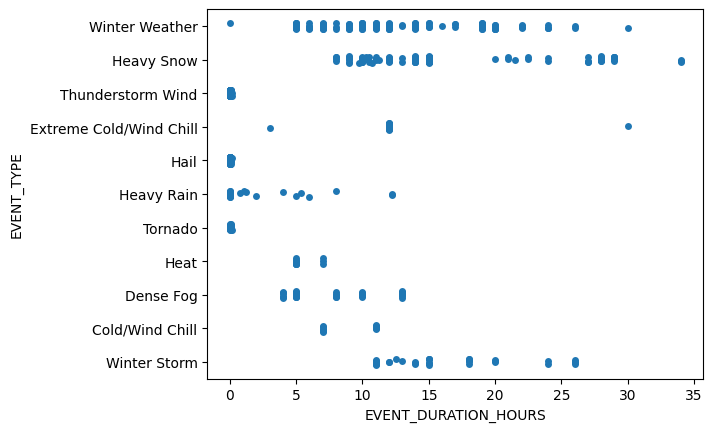

In [38]:
#@title Solution: plotting {display-mode: "form"}

# plot the distribution of event durations as a stripplot with points using seaborn
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

storms_no_flood = storms_filtered[~storms_filtered["EVENT_TYPE"].str.contains("Flood")]

# convert EVENT_DURATION to number of hours
storms_no_flood["EVENT_DURATION_HOURS"] = storms_no_flood["EVENT_DURATION"].dt.total_seconds() / 3600

fig, ax = plt.subplots()

ax = sns.stripplot(data=storms_no_flood, x="EVENT_DURATION_HOURS", y="EVENT_TYPE")

plt.show()

C:\Users\Gregg\AppData\Local\Temp\ipykernel_38596\42002734.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  storms_flood_only["EVENT_DURATION_HOURS"] = storms_flood_only["EVENT_DURATION"].dt.total_seconds() / 3600


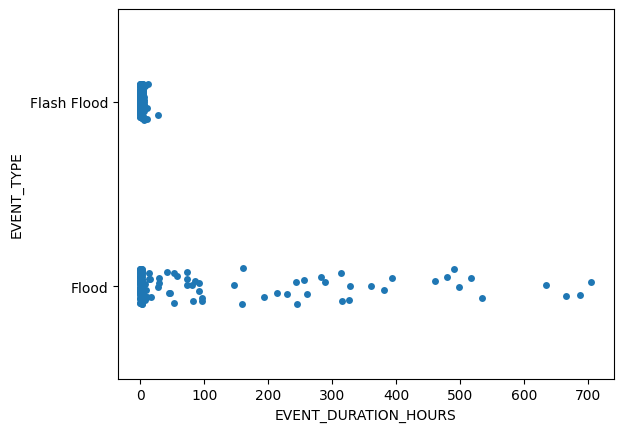

In [39]:
#@title Solution: plotting pt 2 {display-mode: "form"}

# plot the distribution of event durations as a stripplot with points using seaborn
# separately plotting EVENT_TYPE = flood

fig, ax = plt.subplots()

storms_flood_only = storms_filtered[storms_filtered["EVENT_TYPE"].str.contains("Flood")]

# convert EVENT_DURATION to number of hours
storms_flood_only["EVENT_DURATION_HOURS"] = storms_flood_only["EVENT_DURATION"].dt.total_seconds() / 3600

ax = sns.stripplot(data=storms_flood_only, x="EVENT_DURATION_HOURS", y="EVENT_TYPE")

plt.show()